# High Influx filter

This notebook shows the “HI_filter” to detect unrealistically high rainfall rainfall amounts reported by a PWS compared with a reference. 
The original R code stems from https://github.com/LottedeVos/PWSQ

In [3]:
# Import packages

import numpy as np
import poligrain as plg
import xarray as xr
import matplotlib.pyplot as plt

## Load example data
[short description of example data]

In [41]:
# download nc file to current directory. Does not work to read data if I do this, only if I download manually from github (get ValueError)
# !curl -OL https://github.com/OpenSenseAction/OS_data_format_conventions/tree/main/notebooks/data/OpenSense_PWS_example_format_data.nc

In [42]:
#test = xr.open_dataset("OpenSense_PWS_example_format_data.nc")
#test

# old file:
# !curl -OL https://github.com/OpenSenseAction/training_school_opensene_2023/raw/main/data/pws/data_PWS_netCDF_AMS_float.nc

In [4]:
# read PWS data with xarray
ds_pws = xr.open_dataset("C:/Users/a002461/OPENSENSE/data/OpenSense_PWS_example_format_data.nc")  

#rename to follow opensense naming convention
ds_pws = ds_pws.rename_vars({"longitude": "lon", "latitude": "lat"} )

#slice to time of interest (remove)
#ds_pws = ds_pws.sel(time=slice("2017-09-13 00:00:00", "2017-09-13 03:00"))

ds_pws

<xarray.Dataset>
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 ...
    lat        (id) float64 ...
    lon        (id) float64 ...
Data variables:
    rainfall   (id, time) float32 ...
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

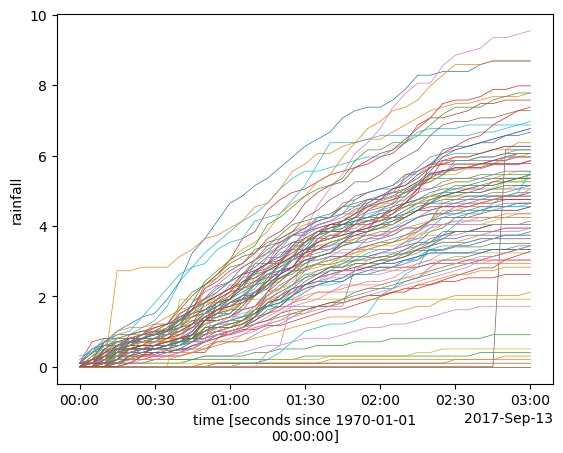

In [20]:
ds_pws.rainfall.cumsum(dim="time").plot.line(x="time", add_legend=False, linewidth=0.5);

In [19]:
round = 1 #set level of accuracy

## Create distance matrix

[Preparations below both apply to HI and FZ filter. Apply poligrain here]


### Reproject coordinates to metric projection to allow for distance calculations 

In [6]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(x=ds_pws.lon, y=ds_pws.lat, target_projection="EPSG:25832")

### Calculate distance between all stations of the network in meters

In [7]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

## Initialize arrays for storing QC flags

In [45]:
FZflag = xr.zeros_like(ds_pws, dtype='bool')
FZflag = FZflag.rename_vars({"rainfall": "FZflag"})
FZflag

<xarray.Dataset>
Dimensions:    (id: 134, time: 219168)
Coordinates:
  * time       (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 ...
    lat        (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    lon        (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
    x          (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    FZflag     (id, time) bool False False False False ... False False False
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

In [47]:
HIflag = xr.zeros_like(ds_pws, dtype='bool')
HIflag = HIflag.rename_vars({"rainfall": "HIflag"})
HIflag #perhaps not smart. Now float32, should be integer

<xarray.Dataset>
Dimensions:    (id: 134, time: 219168)
Coordinates:
  * time       (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 ...
    lat        (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    lon        (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
    x          (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    HIflag     (id, time) bool False False False False ... False False False
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

## Create list of neighbouring stations 

In [8]:
# select stations within range max_distance
pws_id = "ams1"  # ALL?
max_distance = 10e3  # meters

In [9]:
neighbor_ids = distance_matrix.id.data[distance_matrix.sel(id=pws_id) < max_distance]
neighbor_ids

array(['ams1', 'ams2', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8',
       'ams9', 'ams10', 'ams11', 'ams12', 'ams13', 'ams14', 'ams15',
       'ams16', 'ams17', 'ams19', 'ams20', 'ams21', 'ams23', 'ams24',
       'ams26'], dtype='<U6')

## Check if QC filters can be applied

In [53]:
ds_pws.rainfall.sel(id=neighbor_ids).isnull().sum(dim="id")

<xarray.DataArray 'rainfall' (time: 219168)>
array([8, 8, 8, ..., 5, 5, 5])
Coordinates:
  * time     (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01

In [55]:
ds_pws

<xarray.Dataset>
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 ...
    lat        (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    lon        (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
    x          (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall   (id, time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 nan 0.0 0.0 0.0
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

In [ ]:
N_neighbors_not_nan = []

for i in ...


ds_pws['N_neighbors_non_nan'] = N_neighbors_not_nan

In [17]:
# filter cannot be applied if less than nstat stations are reporting data within range max_distance -- initialize flags earlier? 
# HIflag[xr.where(N < nstat)] = -1
#test = ds_pws.sel(id=neighbor_ids).rainfall.notnull
test = ds_pws.rainfall.notnull(keep_attrs=True)


#N = number of stations not-NaN within range d around station i
test

<xarray.DataArray 'rainfall' (id: 134, time: 219168)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * time       (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 ...
    lat        (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    lon        (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
    x          (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Attributes:
    name:                   rainfall
    long_name:              rainfall amount per time unit
    units:                  mm
    coverage_contant_type:  physicalMeasurement

In [15]:
np.size(test)

1

In [13]:
# Calculate median
# reference = ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id")

reference = ds_pws.rainfall.median(dim="id")
reference

<xarray.DataArray 'rainfall' (time: 219168)>
array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01

### _Checking median behaviour_

In [59]:
#rain for certain timestep 
#ds_pws.sel(id=neighbor_ids, time="2017-09-13 00:10:00").rainfall.round(round)
mediantest = ds_pws.sel(time="2017-09-13 01:30:00").rainfall.round(1)
mediantest

<xarray.DataArray 'rainfall' (id: 134)>
array([0.2, 0. , 0.1, 0.1, nan, 0.1, 0.1, 0. , 0. , 0.2, 0. , 0. , 0.1,
       0.1, 0.2, nan, 0.1, 0.1, 0.2, 0.2, 0.3, 0.2, nan, 0.1, nan, 0.2,
       0.1, 0.2, 0.2, 0.2, 0.1, 0.1, nan, 0.2, 0.3, nan, 0.2, nan, 0.2,
       nan, nan, 0. , 0.1, 0.1, nan, nan, 0.1, nan, nan, 0.2, nan, 0.1,
       0.1, 0. , 0.2, 0.3, nan, 0.2, 0. , nan, 0. , 0.2, 0. , 0.5, 0.1,
       nan, nan, 0.2, 0.5, 0.4, 0.3, 0.2, 0. , nan, nan, 0. , nan, nan,
       0.3, 0.3, 0.2, 0.4, 0. , 0.4, 0.2, 0.3, 0.1, 0.3, nan, nan, nan,
       0. , nan, 0.4, 0.2, 0.4, 0.1, 0.2, 0.4, 0.3, nan, nan, 0.3, nan,
       0.4, 0.3, 2. , 0.3, nan, nan, 0.5, 0.1, nan, 0.4, 0.2, 0.4, 0.3,
       nan, 0.4, 0.4, 0.3, 0.2, 0.3, 0.3, nan, nan, 0.1, 0.4, nan, nan,
       nan, nan, 0.3, 0.2], dtype=float32)
Coordinates:
    time       datetime64[ns] 2017-09-13T01:30:00
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 ...
    lat        (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    lon        (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
    x          (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Attributes:
    name:                   rainfall
    long_name:              rainfall amount per time unit
    units:                  mm
    coverage_contant_type:  physicalMeasurement

In [58]:
#ds_pws.sel(id=neighbor_ids, time="2017-09-13 00:10:00").rainfall

#median = mediantest.sel(id=neighbor_ids, time="2017-09-13 00:10:00").rainfall.median(dim="id")
median = mediantest.sel(id=neighbor_ids).median(dim="id")
median.data


array(0.101)

## Calculate reference

The default reference of the filter is to compare the observed rainfall of a given station with the median rainfall from all stations within a range `max_distance`. If the median is below the threshold value `HIthresA`, the HI flag for the station is set to 1 (i.e. high influx) for rainfall amounts above threshold `HIthresB`. When the surrounding stations report moderate to heavy rainfall, the threshold becomes variable: for a median of `HIthresA` or higher, the station's HI flag is set to 1 when its measurements exceed the median times `HIthresB/HIthresA`. HI flag is set to −1 if fewer stations than treshold `nstat` are reporting observations.

_Allow for other metrics in addition to median? Stochastic methods? Propose other metrics for variable_ `reference`? Compare with secondary data?

In [28]:
# Calculate median of neigbouring stations for all time steps
reference = ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id")

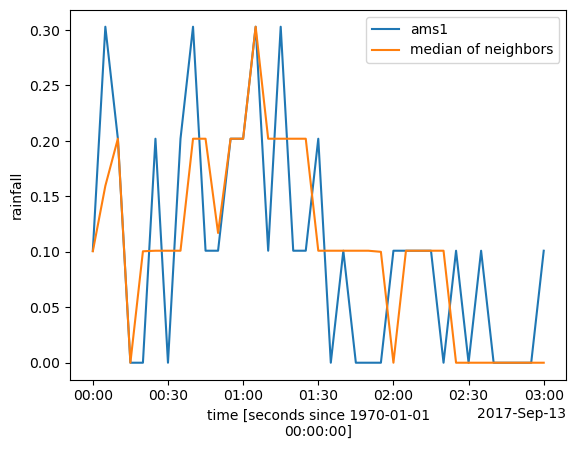

In [25]:
ds_pws.sel(id=pws_id).rainfall.plot(label="ams1")
ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id").plot(label="median of neighbors")

plt.legend();

## Faulty Zeroes filter

In [ ]:
# ...

## High Influx filter

[insert explanation about parameters and their selected values]

In [ ]:
# set parameters
HIthresA = 0.4  # threshold for median rainfall of stations within range d, mm
HIthresB = 10  # upper rainfall limit, mm

In [ ]:
# filter cannot be applied if less than nstat stations are reporting data within range d (same for FZ filter) MOVE?!?
# N = number of stations not-NaN within range d around station i
# nstat = 5 # threshold for nr of stations within range d reporting data

HIflag[xr.where(nstat > N)] = -1

In [ ]:
for i in np.arange(np.shape(pws_data)[0]):
    condition1 = (reference < HIthresA) & (pws_data[:, i] > HIthresB)
    condition2 = (reference >= HIthresA) & (
        pws_data[:, i] > HIthresB / HIthresA * reference
    )
    HIflag[xr.where(condition1 | condition2)] = 1

## Station Outlier filter

In [ ]:
# ...

## Bias calculation 

In [ ]:
# ...